In [93]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import plotly.express as px
import numpy as np
import folium
from pyproj import Transformer
from shapely.geometry import Point
pd.set_option('display.max_rows', 500)
from IPython.display import display, IFrame, HTML


In [94]:
df = pd.read_csv('data/processed_data.csv', delimiter=',')
df["DATE_TIME"] = pd.to_datetime(df["DATE_TIME"], format='mixed')
df.head()

,SITE_ID,LOCATION,DATE_TIME,NO,NOX,NO2,PM2_5,PM10,Latitude,Longitude
0,188,AURN Bristol Centre,1993-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,51.457204,-2.585649
1,188,AURN Bristol Centre,1993-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,51.457204,-2.585649
2,188,AURN Bristol Centre,1993-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,51.457204,-2.585649
3,188,AURN Bristol Centre,1993-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,51.457204,-2.585649
4,188,AURN Bristol Centre,1993-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN,51.457204,-2.585649


In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1607930 entries, 0 to 1607929
Data columns (total 10 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   SITE_ID    1607930 non-null  int64         
 1   LOCATION   1607930 non-null  object        
 2   DATE_TIME  1607930 non-null  datetime64[ns]
 3   NO         1478294 non-null  float64       
 4   NOX        1471958 non-null  float64       
 5   NO2        1469173 non-null  float64       
 6   PM2_5      150898 non-null   float64       
 7   PM10       357573 non-null   float64       
 8   Latitude   1607930 non-null  float64       
 9   Longitude  1607930 non-null  float64       
dtypes: datetime64[ns](1), float64(7), int64(1), object(1)
memory usage: 122.7+ MB


In [96]:
start_date = '2020-11-28 00:00:00'
end_date = '2024-11-28 00:00:00'

date_mask = df['DATE_TIME'].between(start_date, end_date)

sensors_with_data = df.loc[date_mask, 'SITE_ID'].unique()

sensor_coords = df[df['SITE_ID'].isin(sensors_with_data)]
sensor_coords = sensor_coords[['SITE_ID','Latitude', 'Longitude']]
sensor_coords = sensor_coords.drop_duplicates()

print(sensor_coords)

         SITE_ID   Latitude  Longitude
113910       203  51.441747  -2.559956
500141       215  51.432676  -2.604957
699392       270  51.427864  -2.563742
1158036      452  51.462829  -2.584541
1333866      463  51.478045  -2.535230
1475905      500  51.457950  -2.583989
1535088      501  51.455269  -2.596649
1586005      672  51.459142  -2.595433


In [97]:
coords_df = sensor_coords

coords_df = coords_df.drop_duplicates()

map_center = [coords_df['Latitude'].mean(), coords_df['Longitude'].mean()]

sites_map = folium.Map(location=map_center, zoom_start=12)

for index, row in coords_df.iterrows():
    popup_text = f"Lat: {row['Latitude']:.6f}<br>Long: {row['Longitude']:.6f}"

    folium.Marker(
        location = [row['Latitude'], row['Longitude']],
        popup=popup_text,
        tooltip=f"Point {row['SITE_ID']}"
    ).add_to(sites_map)

caz_geojson_url = "data/weca_caz.geojson"

folium.GeoJson(
    caz_geojson_url,
    name='Bristol Clean Air Zone',
    style_function=lambda x: {
        'fillColor': '#4169E1', 
        'color': 'darkblue',
        'weight': 2,
        'fillOpacity': 0.15
    }
).add_to(sites_map)

folium.LayerControl().add_to(sites_map)

sites_map

In [98]:
gdf = gpd.read_file(caz_geojson_url)
target_area = gdf.geometry.iloc[0]

sites_inside_caz = []
sites_outside_caz = []

for row in sensor_coords.values:
    point = Point(row[2], row[1])

    is_inside = target_area.contains(point)

    if is_inside:
        sites_inside_caz.append(row[0])
    else:
        sites_outside_caz.append(row[0])


print(sites_inside_caz)
print(sites_outside_caz)

[500.0, 501.0, 672.0]
[203.0, 215.0, 270.0, 452.0, 463.0]


/var/folders/_k/0mgp9cxj72dcxh4819b8hd740000gn/T/ipykernel_1466/243918640.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample('H')


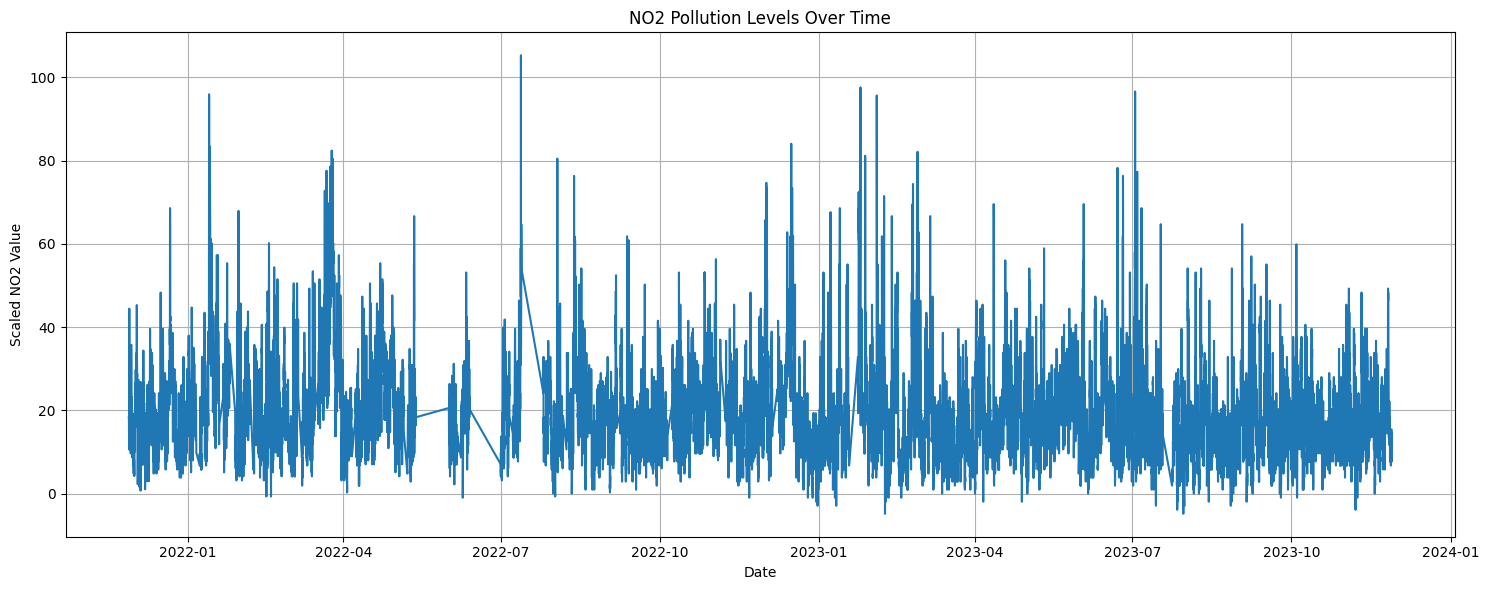

In [99]:
site_no = 500
pollution_type = 'PM10'
start_date = '2021-11-28 00:00:00'
end_date = '2023-11-28 00:00:00'

filter = (df['SITE_ID'] == site_no) & (df['DATE_TIME'].between(start_date, end_date))

site_data = (
    df[filter]
    .set_index('DATE_TIME')
    .sort_index()[pollution_type]
    .resample('H')
    .mean()
    .interpolate(method='linear')
)

plt.figure(figsize=(15, 6))
plt.plot(site_data)
plt.title('NO2 Pollution Levels Over Time')
plt.xlabel('Date')
plt.ylabel('Scaled NO2 Value')
plt.grid(True)
plt.tight_layout()

In [100]:
site_no = 500
pollution_type = 'PM10'
start_date = '2022-11-28 00:00:00'
end_date = '2024-11-28 00:00:00'

filter = (df['SITE_ID'] == site_no) & (df['DATE_TIME'].between(start_date, end_date))

site_data = (
    df[filter]
    .set_index('DATE_TIME')
    .sort_index()[pollution_type]
    .resample('H')
    .mean()
    .fillna(method='ffill')
)

site_data.mean()

/var/folders/_k/0mgp9cxj72dcxh4819b8hd740000gn/T/ipykernel_1466/3159174016.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample('H')
/var/folders/_k/0mgp9cxj72dcxh4819b8hd740000gn/T/ipykernel_1466/3159174016.py:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='ffill')


17.52247728933904

In [ ]:
def show_graphs(inside_caz, start_date='2020-11-28 00:00:00', end_date='2024-11-28 00:00:00'):
    if inside_caz:
        sites = sites_inside_caz
    else:
        sites = sites_outside_caz
    pollutants = ['NO', 'NOX', 'NO2', 'PM10']
    caz_start = '2022-11-28 00:00:00'

    site_data = {}

    before_values = []
    after_values = []
    for site in sites:

        site_data[site] = {'before': {}, 'after': {}}

        for pollutant in pollutants:
            site_data_before = (
                df[(df['SITE_ID'] == site) & (df['DATE_TIME'].between(start_date, caz_start))]
                .set_index('DATE_TIME')
                .sort_index()[pollutant]
                .resample('H')
                .mean()
                .interpolate(method='linear')
            )

            before_mean = site_data_before.mean()
            before_values.append(before_mean)

            site_data_after = (
                df[(df['SITE_ID'] == site) & (df['DATE_TIME'].between(caz_start, end_date))]
                .set_index('DATE_TIME')
                .sort_index()[pollutant]
                .resample('H')
                .mean()
                .interpolate(method='linear')
            )

            after_mean = site_data_after.mean()
            after_values.append(after_mean)

            site_data[site]['before'][pollutant] = before_mean
            site_data[site]['after'][pollutant] = after_mean

    bar_width = 0.35
    x = np.arange(len(pollutants))

    num_sites = len(sites)
    rows = int(np.ceil(np.sqrt(num_sites)))
    cols = int(np.ceil(num_sites / rows))

    fig, axes = plt.subplots(rows, cols, figsize=(12, 5 * rows))
    axes = axes.flatten()

    for i, site in enumerate(sites):
        ax = axes[i]
        data = site_data[site]

        before_values = [data['before'][p] for p in pollutants]
        after_values = [data['after'][p] for p in pollutants]

        ax.bar(x - bar_width/2, before_values, bar_width, label='Before CAZ', color='skyblue')
        ax.bar(x + bar_width/2, after_values, bar_width, label='After CAZ', color='lightgreen')

        ax.set_xlabel('Pollutant Type')
        ax.set_ylabel('Average Concentration')
        ax.set_title(f'Site {site}')
        ax.set_xticks(x)
        ax.set_xticklabels(pollutants)
        ax.legend(title='Time Period')

    for j in range(num_sites, len(axes)):
        fig.delaxes(axes[j])

    if inside_caz:
        plt.suptitle('Pollution Levels Inside CAZ Before and After CAZ Implementation')
    else:
        plt.suptitle('Pollution Levels Outside CAZ Before and After CAZ Implementation')
    plt.tight_layout()
    plt.show()

/var/folders/_k/0mgp9cxj72dcxh4819b8hd740000gn/T/ipykernel_1466/2015999256.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample('H')
/var/folders/_k/0mgp9cxj72dcxh4819b8hd740000gn/T/ipykernel_1466/2015999256.py:34: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample('H')


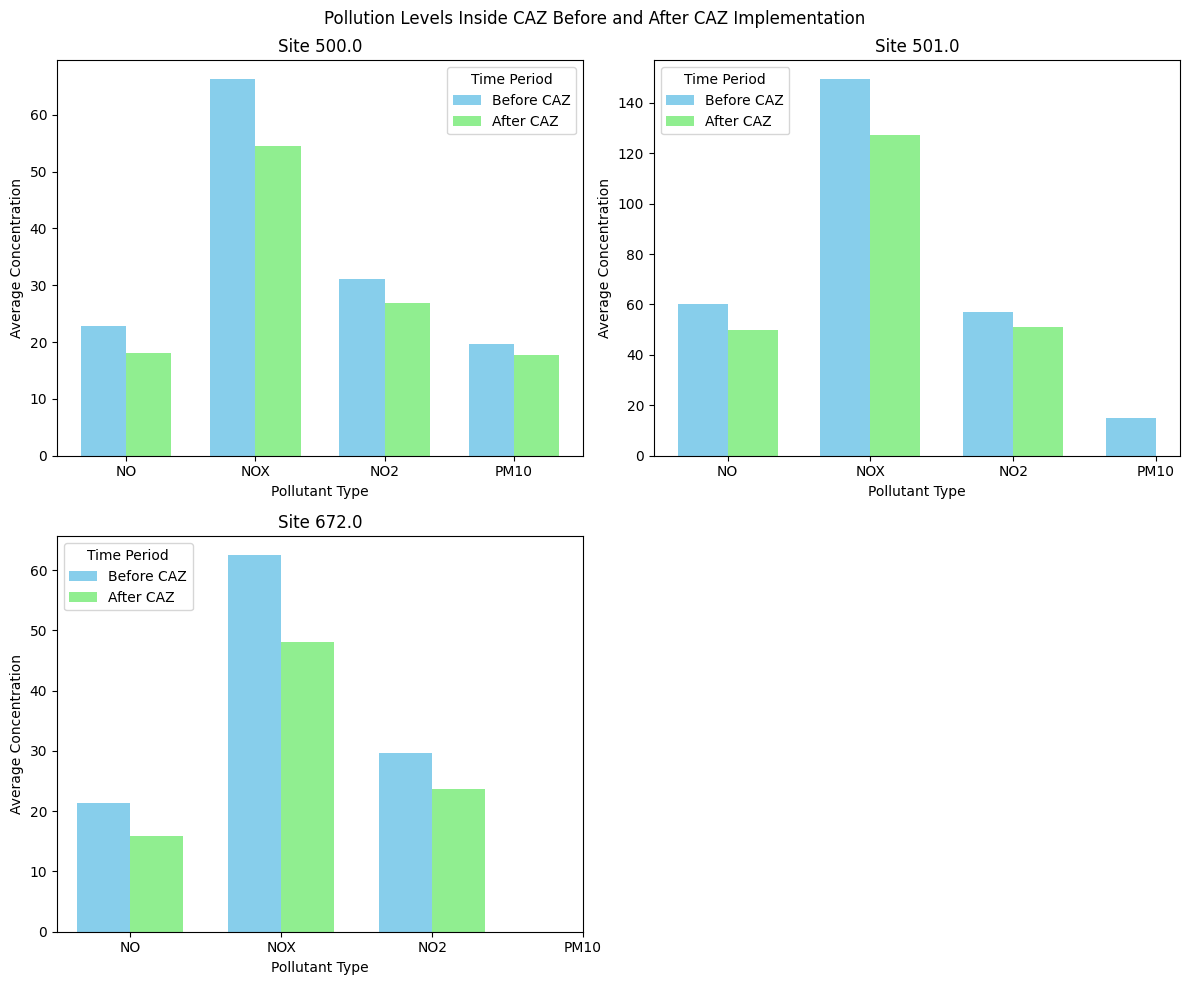

In [123]:
show_graphs(inside_caz=True)

/var/folders/_k/0mgp9cxj72dcxh4819b8hd740000gn/T/ipykernel_1466/2015999256.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample('H')
/var/folders/_k/0mgp9cxj72dcxh4819b8hd740000gn/T/ipykernel_1466/2015999256.py:34: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample('H')


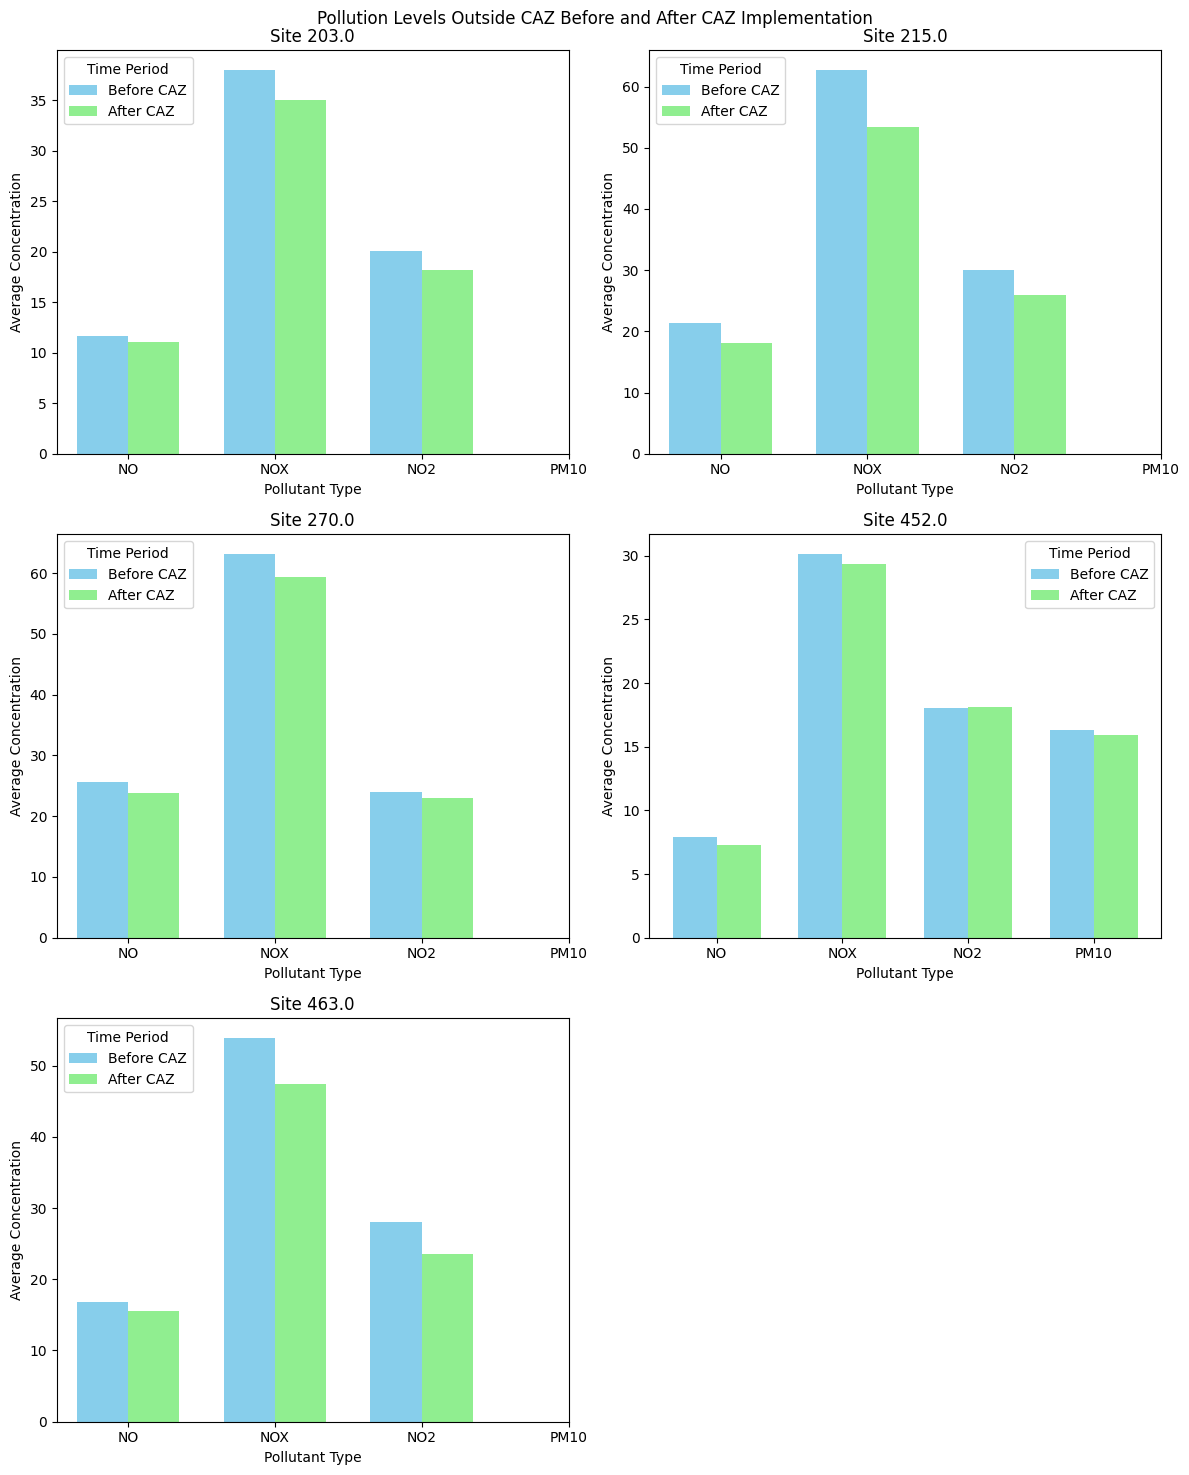

In [124]:
show_graphs(inside_caz=False)